In [ ]:
import time
import numpy as np
import ot
import ot.plot
import matplotlib.pyplot as plt
from ToyTrajectoryNet.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from ToyTrajectoryNet.utils import sample

In [ ]:
df_petal = make_diamonds()
df_dyngen = make_dyngen_data(phate_dims=5)

Calculating PHATE...
  Running PHATE on 1000 observations and 135 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.10 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.26 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 0.44 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.12 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 21.48 seconds.
Calculated PHATE in 22.31 seconds.


In [ ]:
def interpolate(df, time:list, sample_size:float, alpha:float):
  xs = sample(df, time[0], size=sample_size, replace=False, to_torch=False, use_cuda=False)
  xt = sample(df, time[1], size=sample_size, replace=False, to_torch=False, use_cuda=False)
  M = ot.dist(xs, xt)
  a = ot.unif(xs.shape[0])
  b = ot.unif(xt.shape[0])
  T = ot.emd(a, b, M)
  mx = T.max()
  xi = []
  test_bijection = []
  for i in range(xs.shape[0]):
    bij=0
    for j in range(xt.shape[0]):
      if T[i,j] / mx > 0.9:
        bij = 1 + bij
        xi.append(alpha*xs[i] + (1-alpha)*xt[j])
        test_bijection.append(bij)
  return {'xi': np.array(xi), 'xs': xs, 'xt':xt}, test_bijection

In [ ]:
sample_size_petal = 140
sample_size_dyngen = 63

In [ ]:
groups = sorted(df_petal.samples.unique())
petal_interpolation = {}
for step in zip(groups[:],groups[2:]):
    start_time = time.time()
    time_inter = (step[0] + step[1])/2.0
    dt, bij = interpolate(df_petal, step, sample_size = sample_size_petal, alpha=0.5)
    petal_interpolation['inter_time_'+str(int(time_inter))] = dt['xi']
    run_time = time.time() - start_time
    print(run_time)

0.02533268928527832
0.009325027465820312
0.009651660919189453


In [ ]:
petal_interpolation
np.save('petal_interpolation.npy',petal_interpolation)

In [ ]:
groups = sorted(df_dyngen.samples.unique())
dyngen_interpolation = {}
for step in zip(groups[:],groups[2:]):
    start_time = time.time()
    time_inter = (step[0] + step[1])/2.0
    dt, bij = interpolate(df_dyngen, step, sample_size = sample_size_dyngen, alpha=0.5)
    dyngen_interpolation['inter_time_'+str(int(time_inter))] = dt['xi']
    run_time = time.time() - start_time
    print(run_time)

0.005334377288818359
0.0034401416778564453
0.0034630298614501953


In [ ]:
np.save('dyngen_interpolation.npy',dyngen_interpolation)

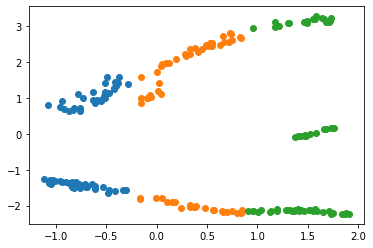

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dyngen_interpolation['inter_time_2'][:,0],dyngen_interpolation['inter_time_2'][:,1])
ax1.scatter(dyngen_interpolation['inter_time_3'][:,0],dyngen_interpolation['inter_time_3'][:,1])
ax1.scatter(dyngen_interpolation['inter_time_4'][:,0],dyngen_interpolation['inter_time_4'][:,1])
plt.show()